# Training 2D: Abs Mag+Stellar Mass
----

<h4> Description </h4>
... tbd

In [1]:
import numpy as np
import astropy.io.ascii as at
import scipy.stats as st
from astropy.table import Table, vstack, join
from astropy.io.fits import getdata

import matplotlib.pyplot as plt
import seaborn as sns; sns.set(color_codes=True)
import os

sns.set_style("whitegrid")
sns.set_context('talk',rc={"lines.linewidth": 2.5})

## Load Training Sample

In [2]:
def transform_to_1d(x,y):
    ynew = y[:,0]
    xnew = np.vstack([x.T,y[:,1]]).T
    return xnew, ynew[:,np.newaxis]

In [3]:
path = '/data/des61.a/data/johnny/COSMOS/fnal2022/'
x_train = np.load(path+'x_train.npy')
y_train = np.load(path+'y_train.npy')

x_test = np.load(path+'x_test.npy')
y_test = np.load(path+'y_test.npy')

In [4]:
x_test1d, y_test1d = transform_to_1d(x_test,y_test)
x_train1d, y_train1d = transform_to_1d(x_train,y_train)

In [34]:
## load target data
fname = '../data/des_sdssGalexWISE_matched.csv'
data = at.read(fname)

mags = np.c_[[data['sof_cm_mag_corrected_%s'%bp_filter] for bp_filter in ['g','r','i','z']]].T
mags_err = np.c_[[data['sof_cm_mag_err_%s'%bp_filter] for bp_filter in ['g','r','i','z']]].T
mask= data['sdss_mass']>0.
ztrue= data['sdss_z']
ytrue= np.array(data['sdss_mass'][mask])

x_target = get_input_galpro(mags[mask],ztrue[mask])

from astropy.cosmology import WMAP9 as cosmo

distMod = cosmo.distmod(ztrue[mask]).value
absMags = x_target[:,:4]-distMod[:,np.newaxis]
x_target1d = np.c_[x_target,absMags[:,2]]

# Training Model

In [5]:
import sys

sys.path.append('/data/des81.a/data/jesteves/GitHub/galpro')
from galpro import model
from galpro.convert_mag_to_lupmag import get_input_galpro

/cvmfs/des.opensciencegrid.org/fnal/anaconda2/envs/des18a/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


# With Abs Mag

In [8]:
gp_root = '/data/des61.a/data/johnny/DESY3/galpro_files/AbsMag/'
target_features = ['$\log(M_{\star} / M_{\odot})$']

gpmodel = model.Model('model_1d', x_train1d, y_train1d, x_test1d, y_test1d, target_features,
                      root=gp_root, save_model=True)


Training model...


/data/des81.a/data/jesteves/GitHub/galpro/galpro/model.py:111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.model.fit(self.x_train, self.y_train)


Saved model.


In [27]:
point_estimates = gpmodel.point_estimate(save_estimates=True, make_plots=False)


Generating point estimates...
Saved point estimates. Any previously saved point estimates have been overwritten.


Creating scatter plots...


/cvmfs/des.opensciencegrid.org/fnal/anaconda2/envs/des18a/lib/python2.7/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family [u'Helvetica'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


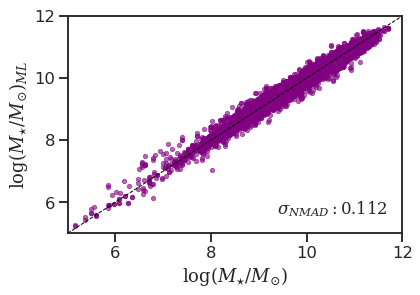

In [10]:
gpmodel.plot_scatter(show=True, save=True)


In [21]:
y_target1d = gpmodel.model.predict(x_target1d)

In [110]:
def plot_scatter(x,y,ax=None,s=20,alpha=0.5,title='',xlims=(mlow,12.5)):
    if ax is None: ax = plt.axes()
    res = (x-y)
    nmad = median_abs_deviation(res[x>=xlims[0]],scale=1/1.4826)
    
    ax.plot(xlims,xlims,'k--',lw=2)
    ax.scatter(x,y,s=s,alpha=alpha,label=r'$\sigma_{NMAD} = %.2f\; dex$'%nmad)
    ax.set_title(title)

def median_abs_deviation(x,scale=1.0):
    return np.median(np.abs(x-np.median(x)))/scale

In [111]:
y_test1d.ravel()

array([9.36706, 9.17647, 9.53564, ..., 9.23462, 9.06659, 9.51096])

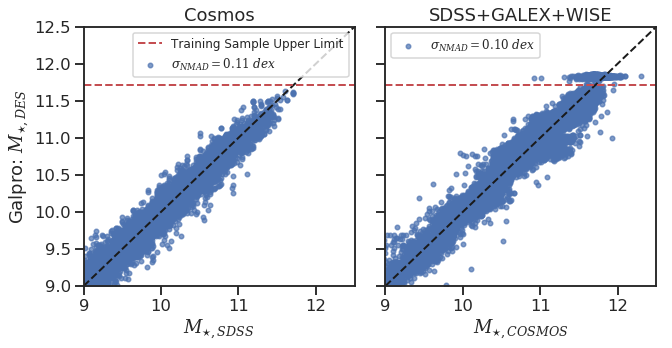

In [112]:
mlow=9.
fig, axis = plt.subplots(1, 2, figsize=(9.5,5), sharex='all',sharey='all')
fig.subplots_adjust(wspace=0.04)
plot_scatter(y_test1d.ravel(), point_estimates,
             ax=axis[0],s=20,alpha=0.7,title='Cosmos',xlims=(mlow,12.5))

plot_scatter(ytrue, y_target1d-np.median(y_target1d-ytrue),
             ax=axis[1],s=20,alpha=0.7,title='SDSS+GALEX+WISE',xlims=(mlow,12.5))

axis[0].axhline(np.max(y_test1d),color='r',ls='--',lw=2,label='Training Sample Upper Limit')
axis[1].axhline(np.max(y_test1d),color='r',ls='--',lw=2)

axis[1].legend(fontsize=12)
axis[0].legend(fontsize=12)
axis[0].set_ylim(9,12.5)
axis[0].set_xlim(9.,12.5)
axis[0].set_xlabel(r'$M_{\star,SDSS}$')
axis[1].set_xlabel(r'$M_{\star,COSMOS}$')
axis[0].set_ylabel(r'Galpro: $M_{\star,DES}$')
fig.tight_layout()
fig.savefig('validation_galpro.png',dpi=100,transparent=False,facecolor='w')

In [131]:
def plot_residual(x,y,z,ax=None,s=20,alpha=0.5,title='',zlims=(0.,0.35)):
    if ax is None: ax = plt.axes()
    res = (x-y)[(x>=9.)]
    nmad = median_abs_deviation(res,scale=1/1.4826)
    
    ax.plot(zlims,[0,0],'k--',lw=2)
    ax.scatter(z[x>=9.],res,s=s,alpha=alpha,label=r'$\sigma_{NMAD} = %.2f\; dex$'%nmad)
    ax.set_title(title)

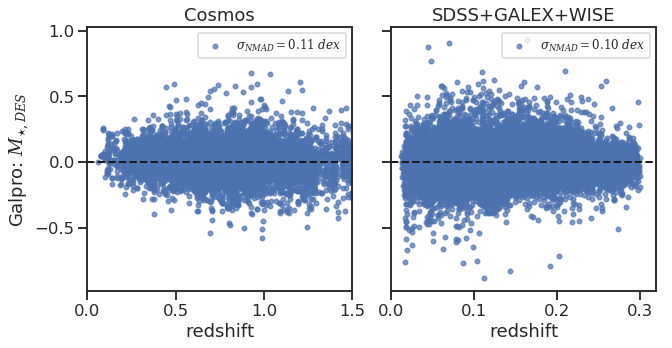

In [134]:
mlow=9.
fig, axis = plt.subplots(1, 2, figsize=(9.5,5),sharey='all')
fig.subplots_adjust(wspace=0.04)
plot_residual(y_test1d.ravel(), point_estimates, x_test[:,-1],zlims=(0.,1.5),
             ax=axis[0],s=20,alpha=0.7,title='Cosmos')

plot_residual(ytrue, y_target1d-np.median(y_target1d-ytrue), x_target[:,-1],
             ax=axis[1],s=20,alpha=0.7,title='SDSS+GALEX+WISE')

# axis[0].axhline(np.max(y_test1d),color='r',ls='--',lw=2,label='Training Sample Upper Limit')
# axis[1].axhline(np.max(y_test1d),color='r',ls='--',lw=2)

axis[1].legend(fontsize=12)
axis[0].legend(fontsize=12)
axis[1].set_xlim(0,0.32)
axis[0].set_xlim(0,1.5)
# axis[0].set_xlim(9.,12.5)
axis[0].set_xlabel(r'redshift')
axis[1].set_xlabel(r'redshift')
axis[0].set_ylabel(r'Galpro: $M_{\star,DES}$')
fig.tight_layout()
# fig.savefig('validation_galpro.png',dpi=100,transparent=False,facecolor='w')

In [53]:
lrgs = (y_target1d-np.median(y_target1d-ytrue))>11.5

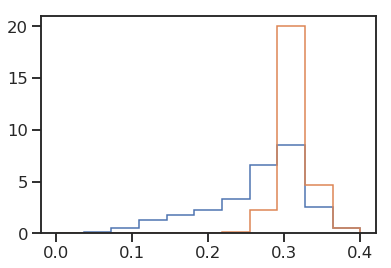

In [60]:
mbins = np.linspace(0.,0.4,12)
_ = plt.hist(x_target[:,2+4],density=True,bins=mbins,histtype='step')
_ = plt.hist(x_target[lrgs,2+4],density=True,bins=mbins,histtype='step')

In [63]:
### Feature Importance

import time
import numpy as np

forest = gpmodel.model
start_time = time.time()
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)
elapsed_time = time.time() - start_time

feature_names = ['mag_%s'%bpF for bpF in ['g','r','i','z']]
feature_names+= ['%s - %s'%(bp0,bp1) for bp0, bp1 in zip(['g','r','i'],['r','i','z'])]

feature_names+= ['Mag_err_%s'%bpF for bpF in ['g','r','i','z']]
feature_names+= ['Err(%s - %s)'%(bp0,bp1) for bp0, bp1 in zip(['g','r','i'],['r','i','z'])]
feature_names+= ['redshift']
feature_names+= ['Mi']
feature_names

print("Elapsed time to compute the importances: {elapsed_time:.3f} seconds".format(elapsed_time=elapsed_time))

Elapsed time to compute the importances: 0.589 seconds


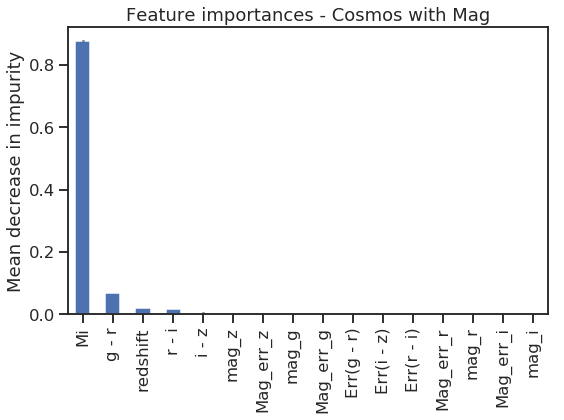

In [64]:
import pandas as pd

ix = np.argsort(-1*importances)
forest_importances = pd.Series(importances[ix], index=np.array(feature_names)[ix])

fig, ax = plt.subplots(figsize=(8,6))
forest_importances.plot.bar(yerr=std[ix], ax=ax)
ax.set_title("Feature importances - Cosmos with Mag")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()
fig.savefig('feature_importance_mag.png',dpi=100,transparent=False,facecolor='w')

In [88]:
# fname = '../data/des_sdssGalexWISE_matched.csv'
# data = at.read(fname)
# mags = np.c_[[data['sof_cm_mag_corrected_%s'%bp_filter] for bp_filter in ['g','r','i','z']]].T
# mags_err = np.c_[[data['sof_cm_mag_err_%s'%bp_filter] for bp_filter in ['g','r','i','z']]].T
# mask = data['sdss_mass']>0.
# ztrue= data['sdss_z']
# ytrue = np.array(data['sdss_mass'])[mask]
# x_target = get_input_galpro(mags[mask],ztrue[mask])
# # x_target1d = transform_to_1d()

## Baseline Model 

We use the standard approach for the features, 4 bands, 3 colors, redshift and the errors.

In [26]:
gp_root = '/data/des61.a/data/johnny/DESY3/galpro_files/AbsMag/'
target_features = ['$\log(M_{\star} / M_{\odot})$', '$M_{i}$']

gpmodel = model.Model('model', x_train, y_train, x_test, y_test, target_features,
                      root=gp_root, save_model=True)


Model directory exists.
Loaded model.


In [31]:
point_estimates = gpmodel.point_estimate(save_estimates=True, make_plots=False)


Generating point estimates...
Saved point estimates. Any previously saved point estimates have been overwritten.


In [6]:
posteriors = gpmodel.posterior(save_posteriors=True, make_plots=False, on_the_fly=False)


Generating posteriors...
Saved posteriors. Any previously saved posteriors have been overwritten.


Creating scatter plots...


/cvmfs/des.opensciencegrid.org/fnal/anaconda2/envs/des18a/lib/python2.7/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family [u'Helvetica'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


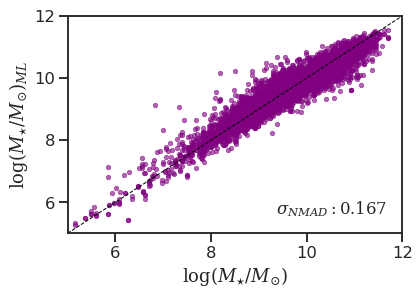

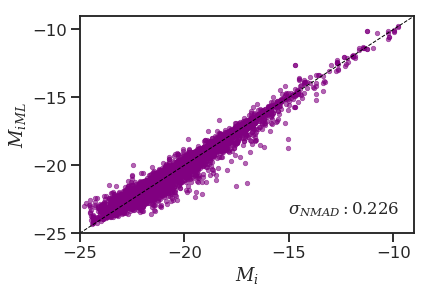

In [7]:
gpmodel.plot_scatter(show=True, save=True)


In [8]:
gpmodel.plot.no_samples = 15

In [8]:
import os

In [ ]:
os.makedirs

Creating posterior plots...


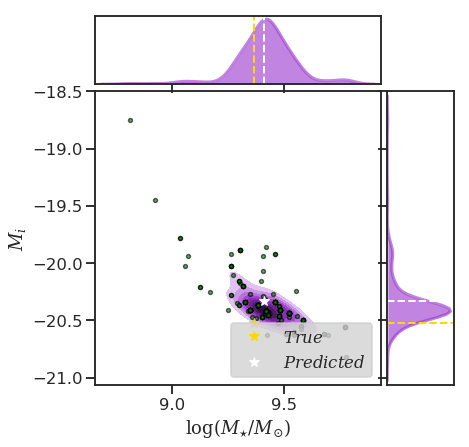

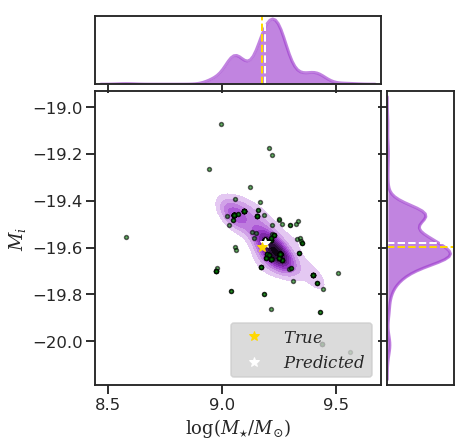

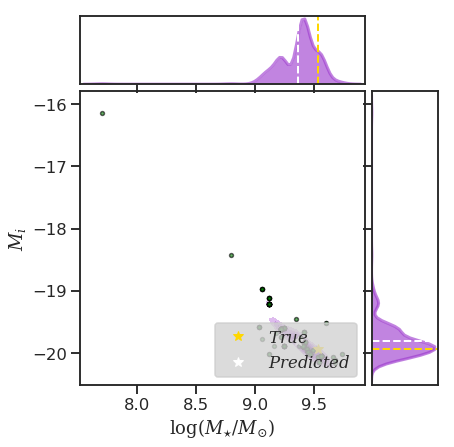

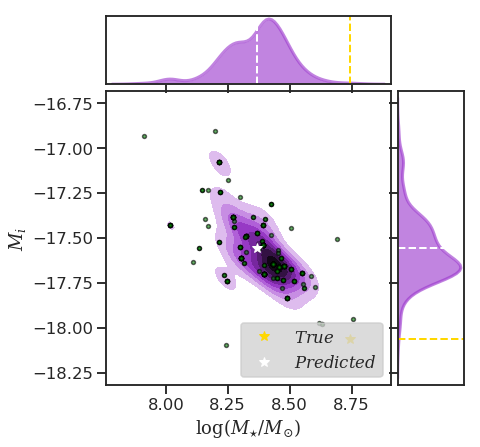

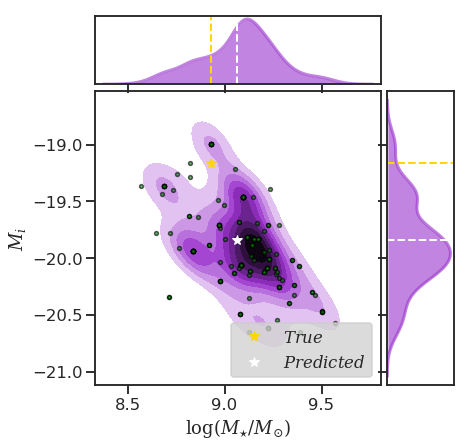

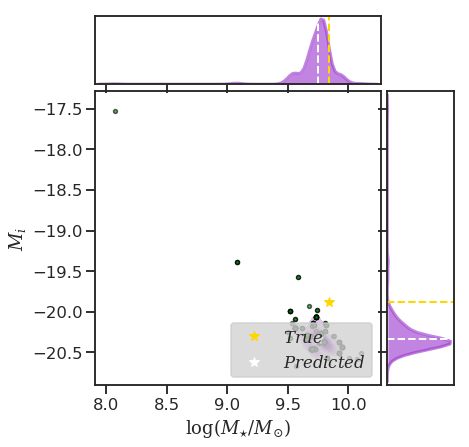

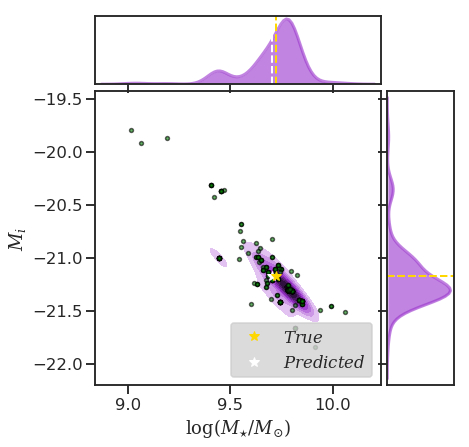

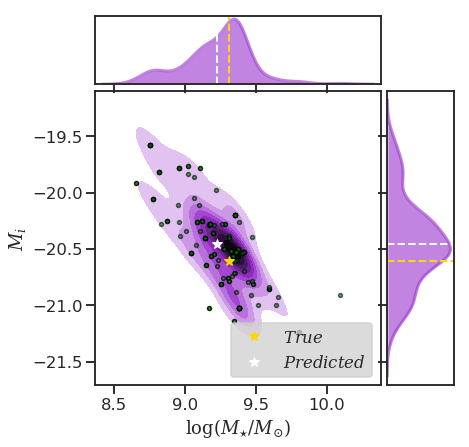

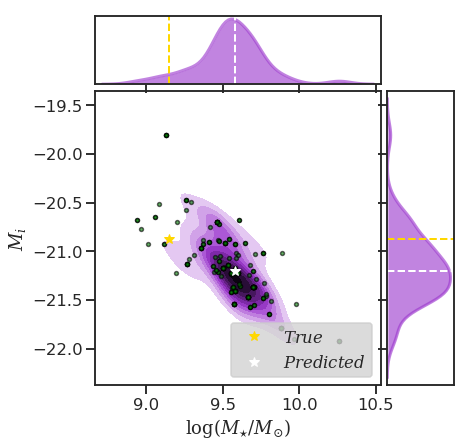

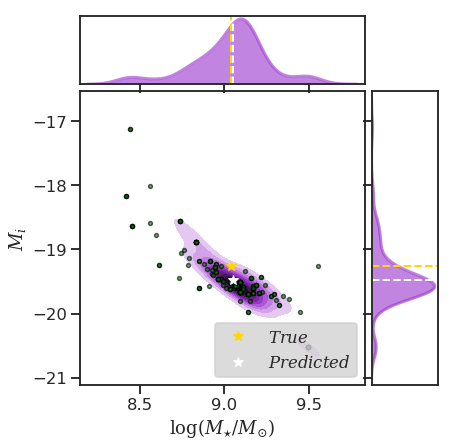

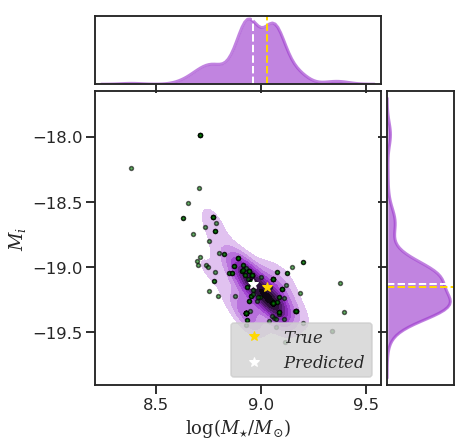

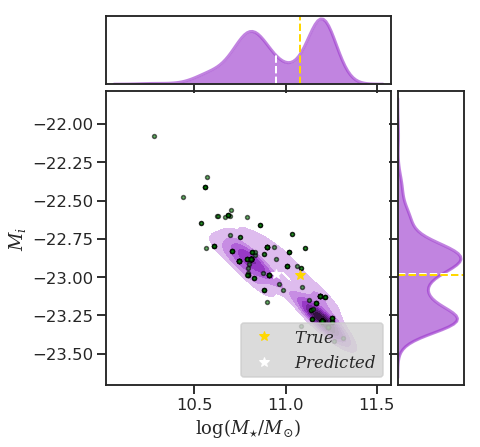

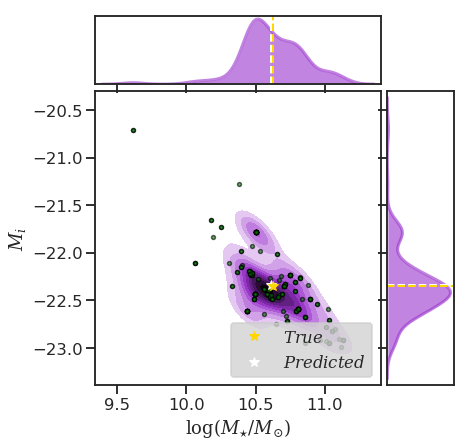

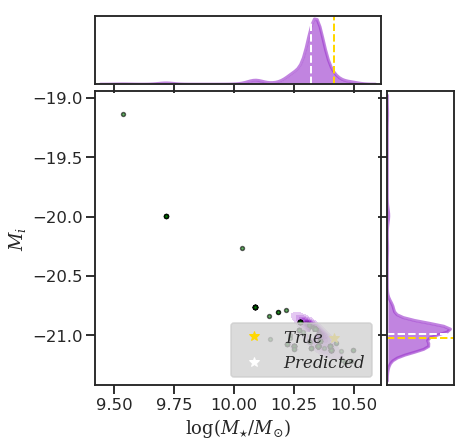

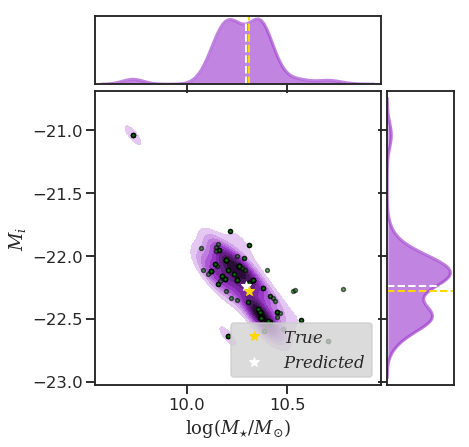

In [9]:
gpmodel.plot_joint(show=True, save=True)

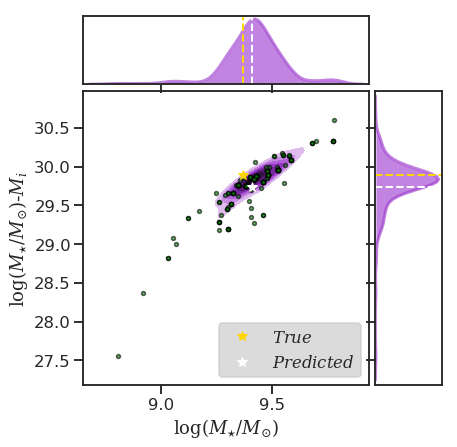

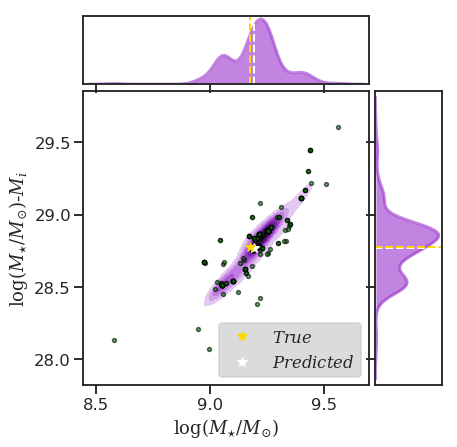

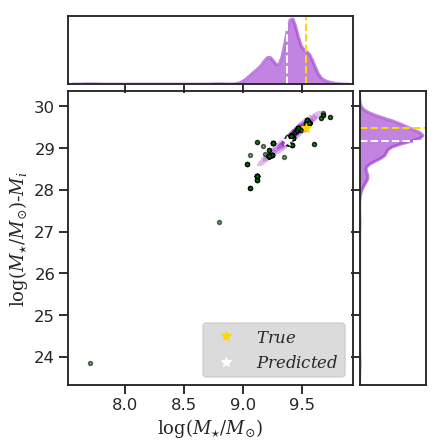

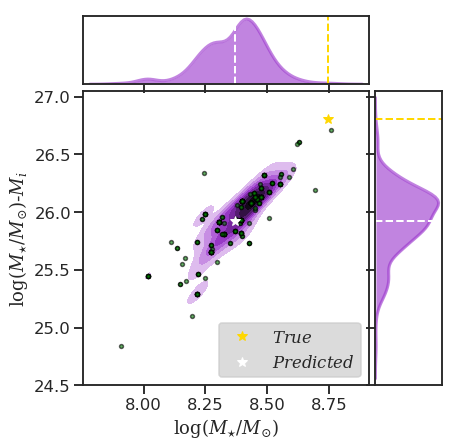

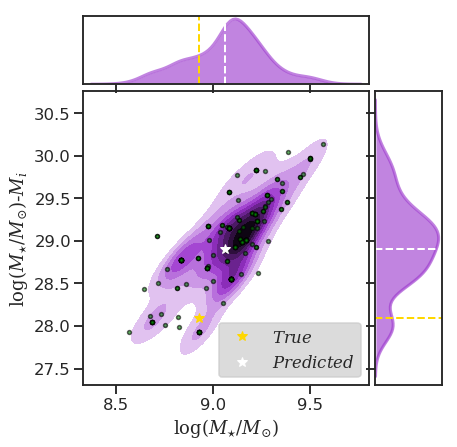

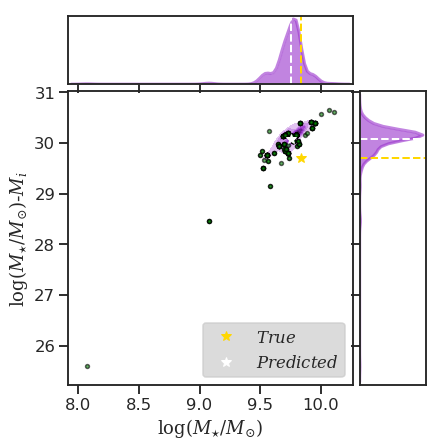

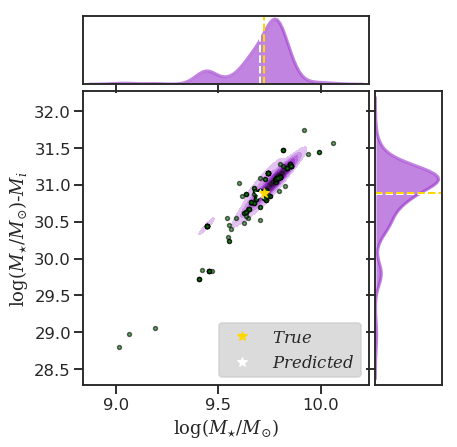

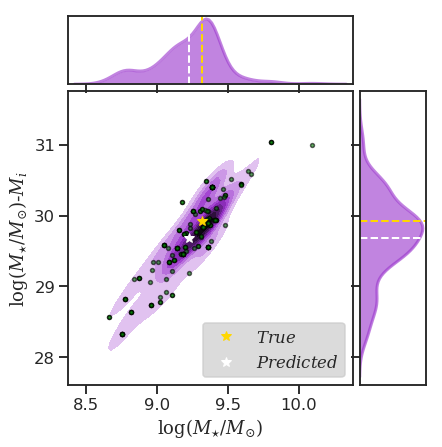

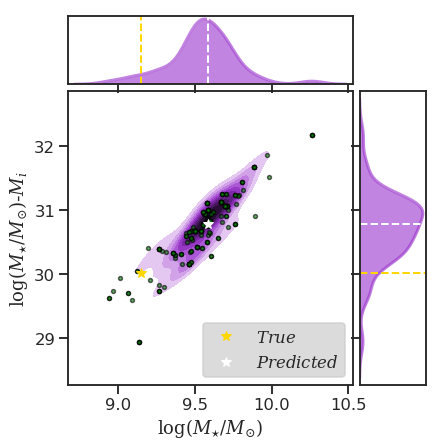

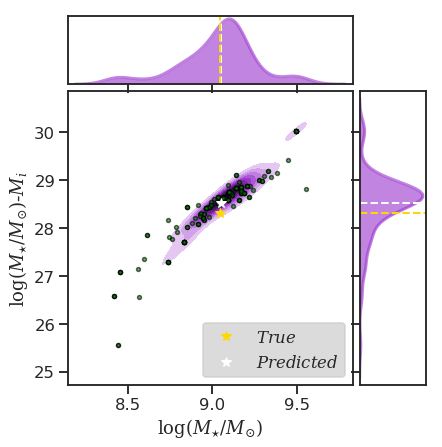

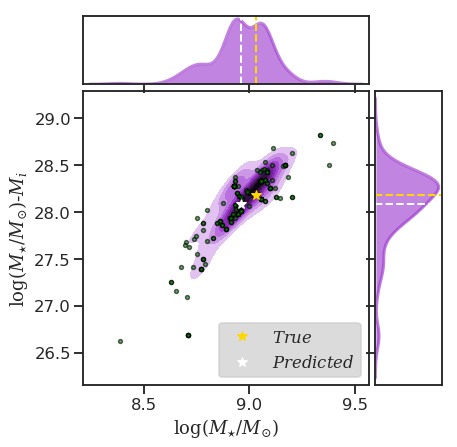

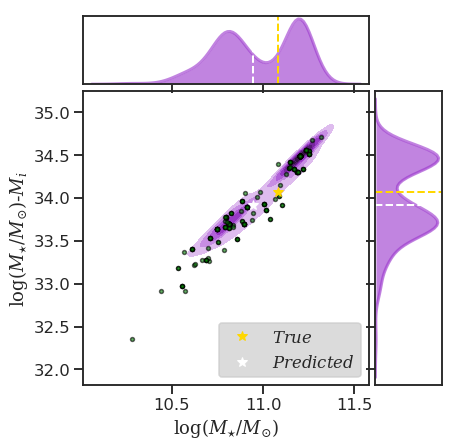

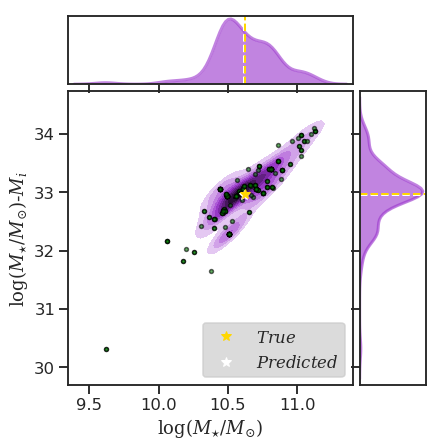

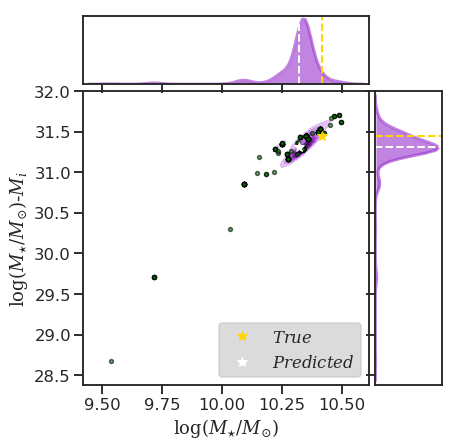

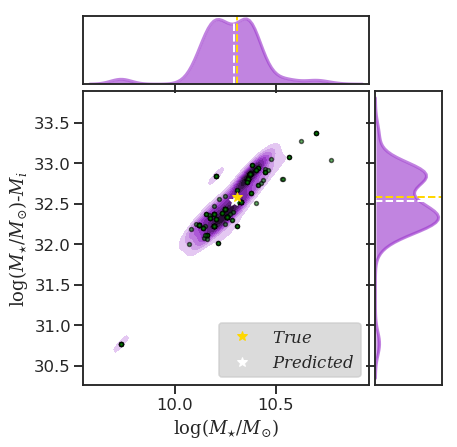

In [11]:
gpmodel.plot.plot_joint_diff(show=True, save=True)

In [13]:
# posteriors['0'][:]


In [74]:
y_target = gpmodel.model.predict(x_target)

## With Pseudo Abs Mag

Instead of using magnitudes, I use a pseud abs mag, which is defined as mag-DM. The distance modules elimanates part of the redshift dependence. It's not an abs mag becuase it lacks the k-correction term.

In [14]:
from astropy.cosmology import WMAP9 as cosmo

def add_pseudo_abs_mag(x):
    xn = x.copy()
    distMod = cosmo.distmod(x[:,-1]).value
    xn[:,:4] = x[:,:4]-distMod[:,np.newaxis]
    return xn

In [75]:
x_train_abs = add_pseudo_abs_mag(x_train)
x_test_abs = add_pseudo_abs_mag(x_test)
x_target_abs = add_pseudo_abs_mag(x_target)

In [54]:
gpmodel_abs = model.Model('model_abs', x_train_abs, y_train, x_test_abs, y_test, target_features,
                      root=gp_root, save_model=True)


Model directory exists.
Loaded model.


In [55]:
point_estimates_abs = gpmodel_abs.point_estimate(save_estimates=True, make_plots=False)


Generating point estimates...
Saved point estimates. Any previously saved point estimates have been overwritten.


In [19]:
posteriors = gpmodel_abs.posterior(save_posteriors=True, make_plots=False, on_the_fly=False)


Generating posteriors...
Saved posteriors. Any previously saved posteriors have been overwritten.


Creating scatter plots...


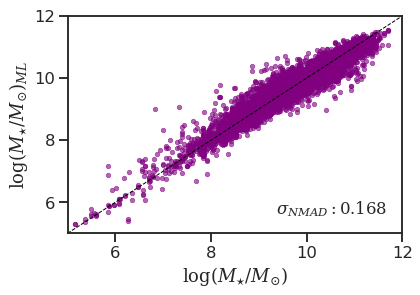

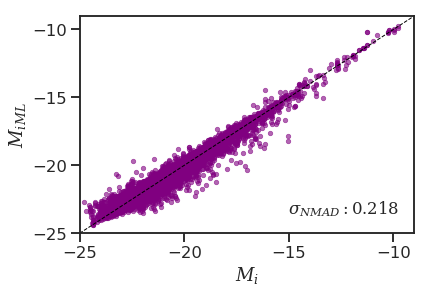

In [20]:
gpmodel_abs.plot_scatter(show=True, save=True)


In [21]:
gpmodel_abs.plot.no_samples = 15

Creating posterior plots...


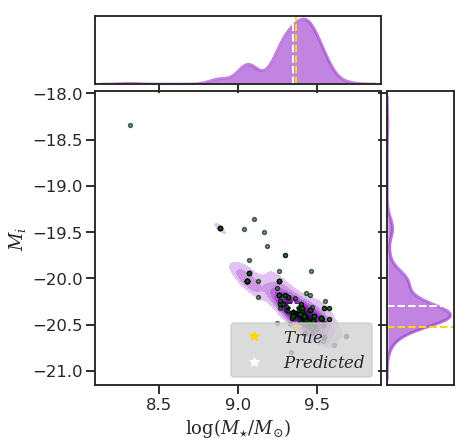

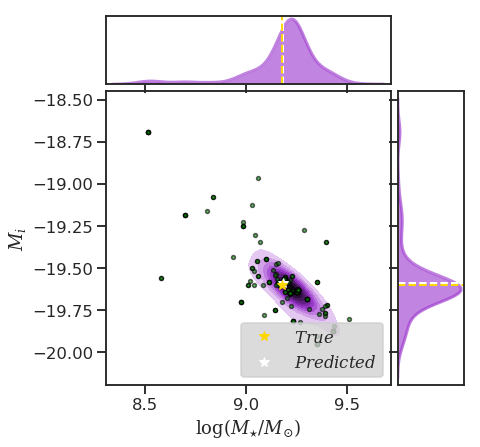

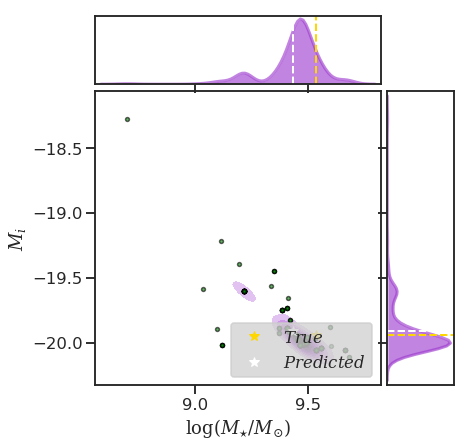

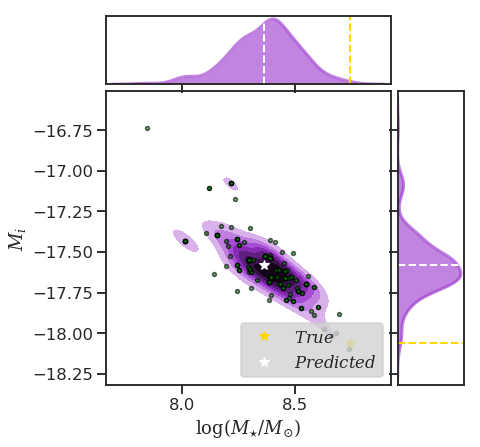

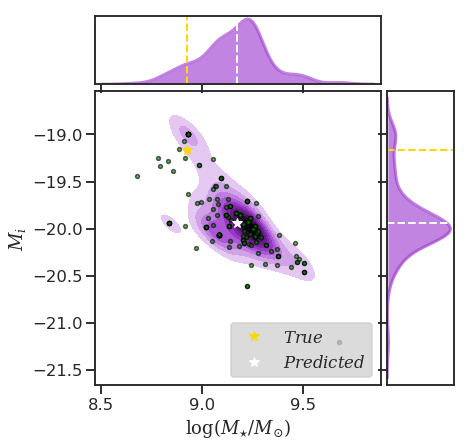

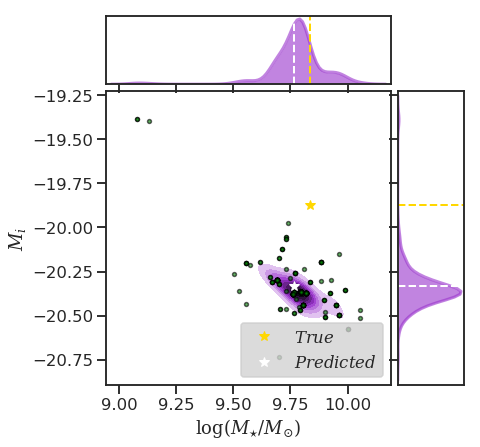

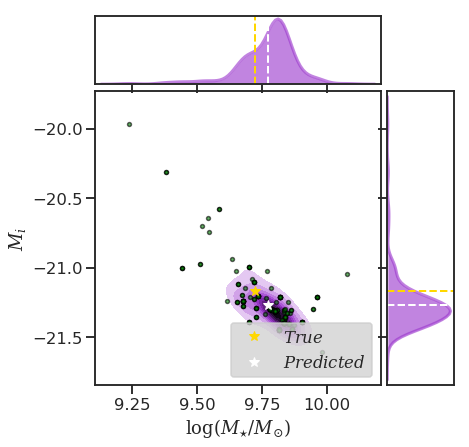

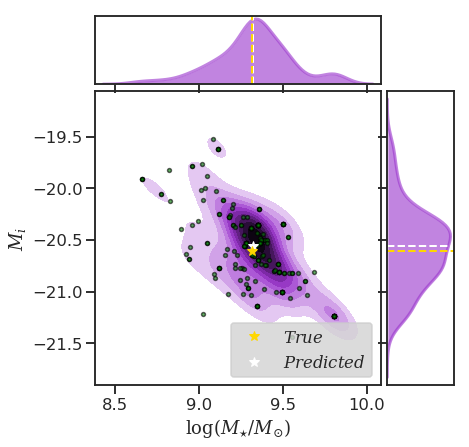

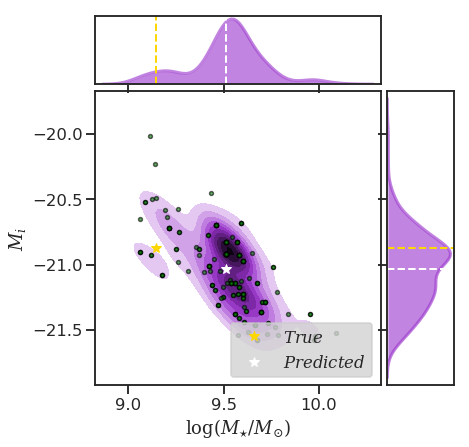

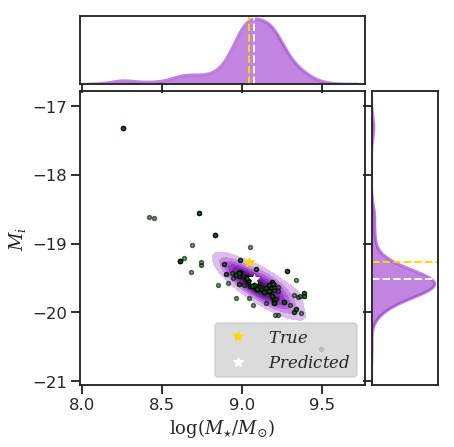

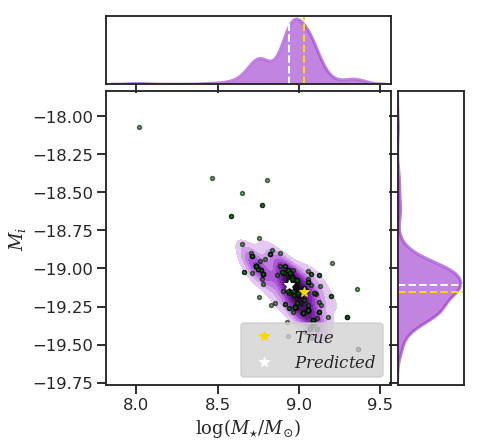

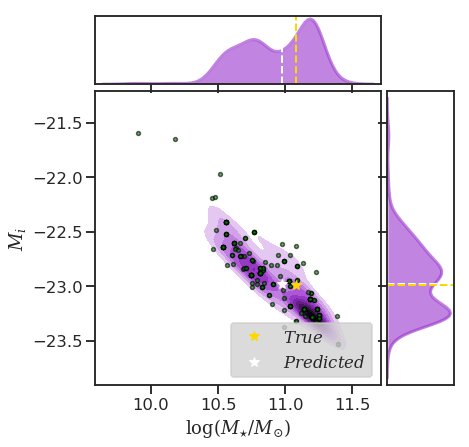

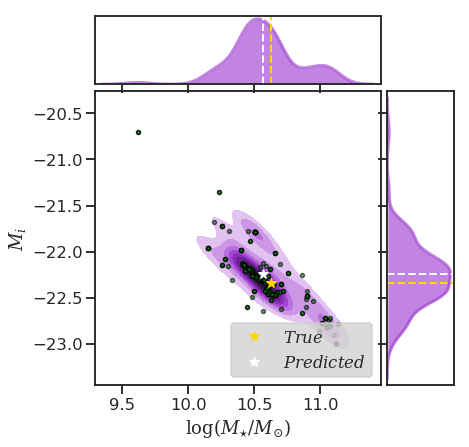

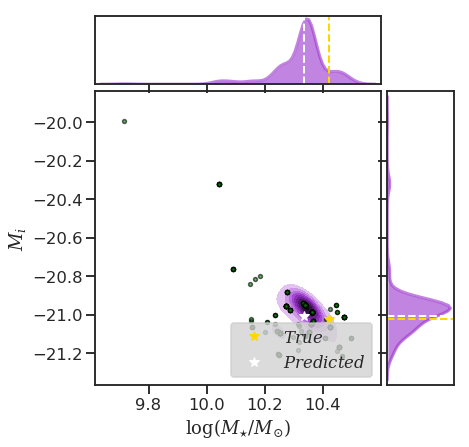

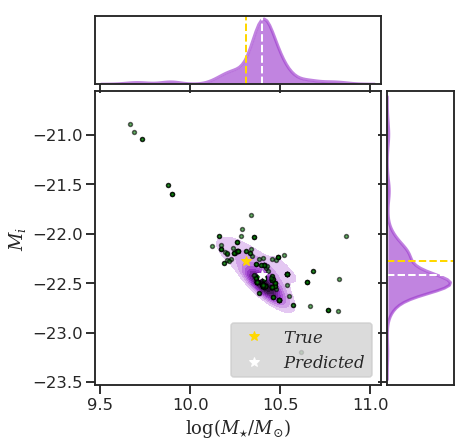

In [22]:
gpmodel_abs.plot_joint(show=True, save=True)

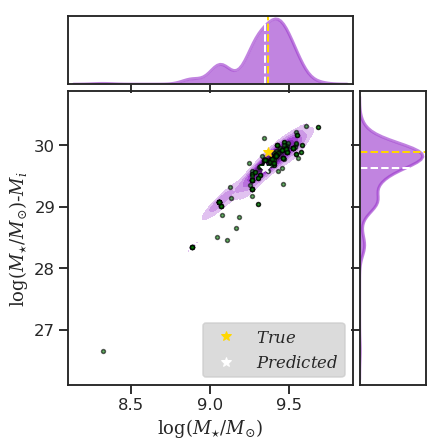

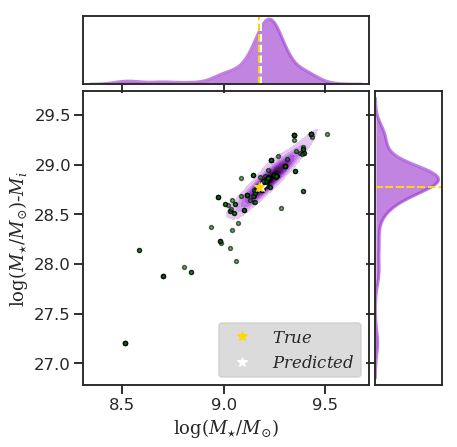

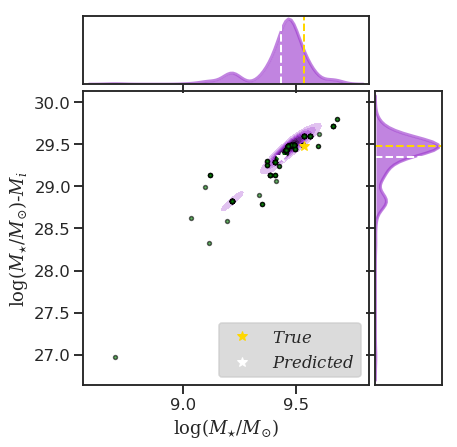

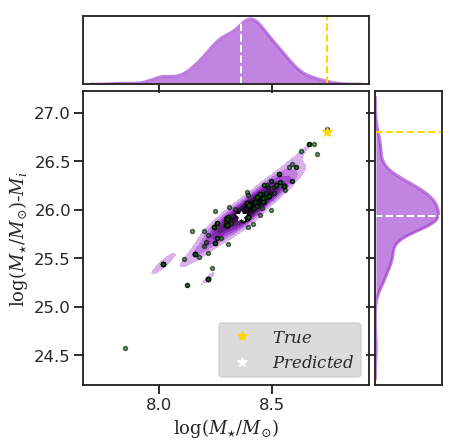

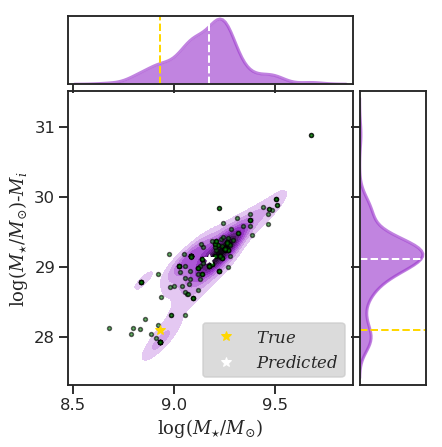

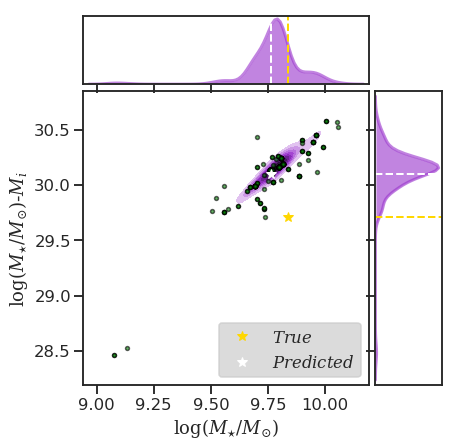

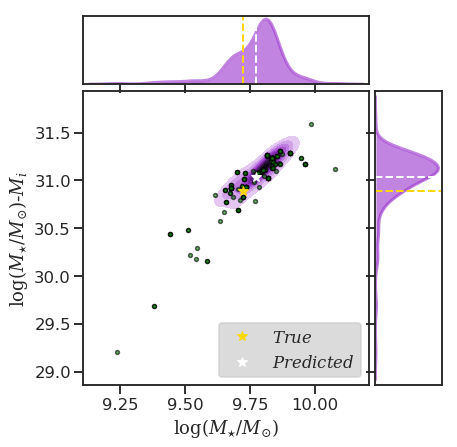

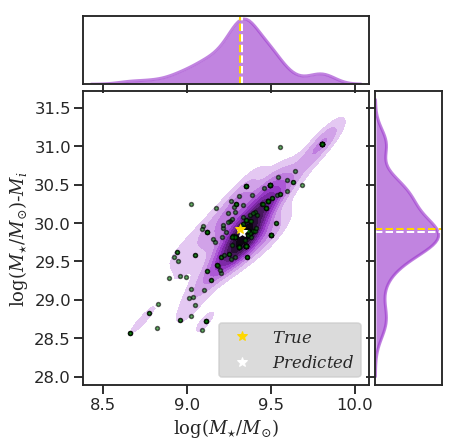

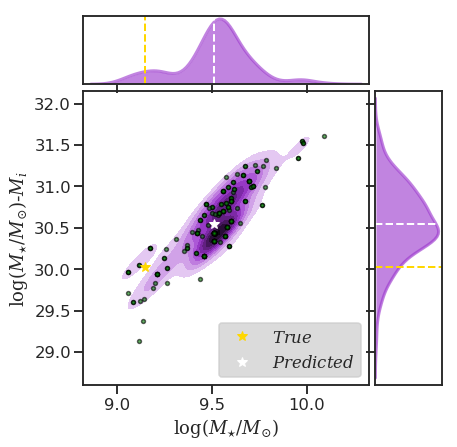

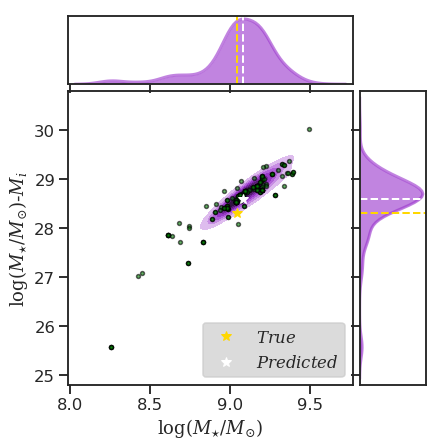

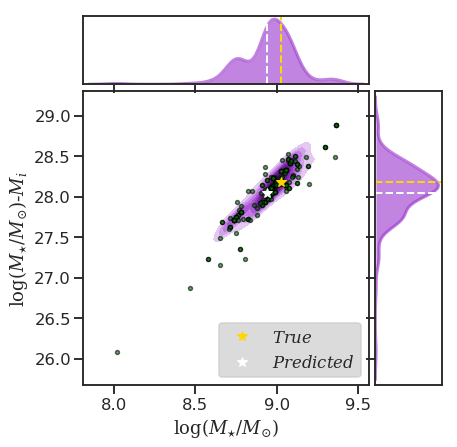

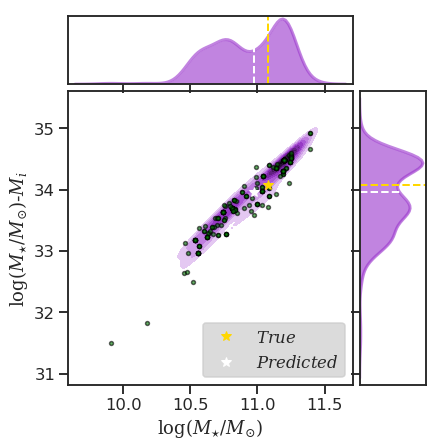

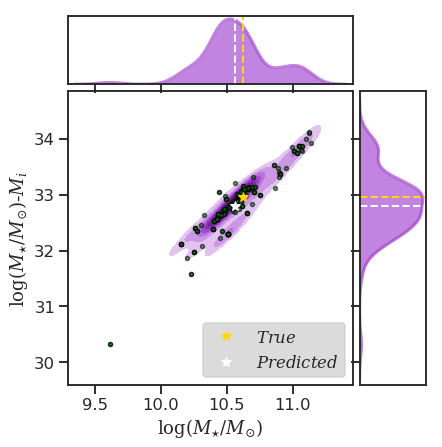

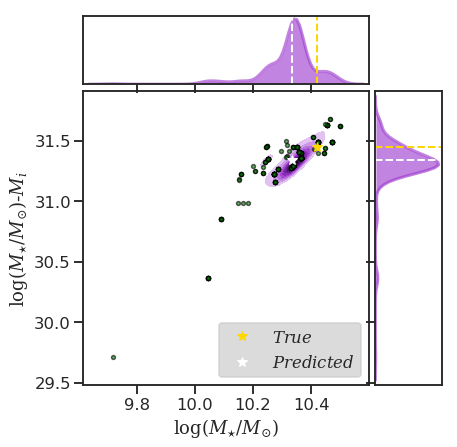

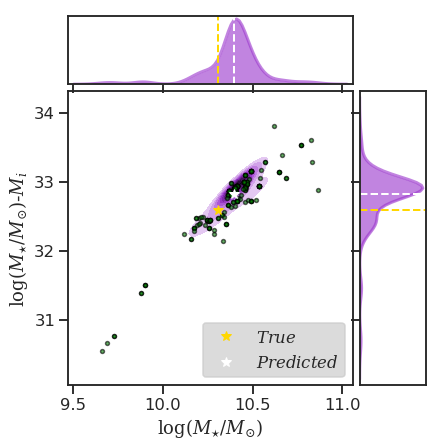

In [23]:
gpmodel_abs.plot.plot_joint_diff(show=True, save=True)

In [24]:
# posteriors['0'][:]


In [93]:
y_target_abs = gpmodel_abs.model.predict(x_target_abs)
point_estimates_abs = gpmodel_abs.model.predict(x_test_abs)

In [94]:
len(y_target_abs)



32218

In [23]:
mlow = 6.
def plot_scatter(x,y,ax=None,s=20,alpha=0.5,title='',xlims=(mlow,12.)):
    if ax is None: ax = plt.axes()
    ax.plot(xlims,xlims,'k--',lw=2)
    ax.scatter(x,y,s=s,alpha=alpha)
    ax.set_title(title)
    

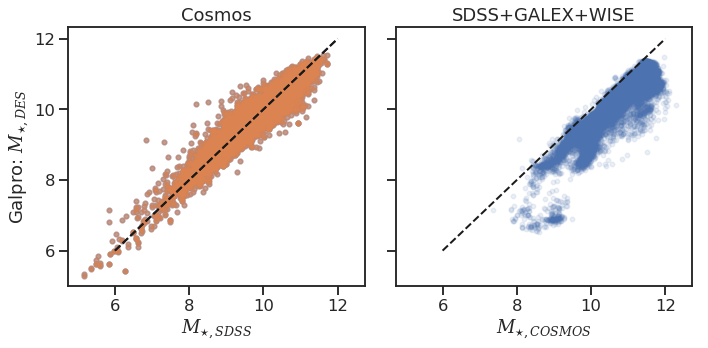

In [102]:
fig, axis = plt.subplots(1, 2, figsize=(10,5), sharex='all',sharey='all')
fig.subplots_adjust(wspace=0.04)
plot_scatter(y_test[:,0], point_estimates[:,0],
             ax=axis[0],s=20,alpha=0.5,title='Cosmos',xlims=(mlow,12.))

plot_scatter(y_test[:,0],point_estimates[:,0],
             ax=axis[0],s=20,alpha=0.5,title='Cosmos',xlims=(mlow,12.))

plot_scatter(ytrue, y_target_abs[:,0],
             ax=axis[1],s=20,alpha=0.1,title='SDSS+GALEX+WISE',xlims=(mlow,12.))

axis[0].set_ylim(mlow-1,)
axis[0].set_xlabel(r'$M_{\star,SDSS}$')
axis[1].set_xlabel(r'$M_{\star,COSMOS}$')
axis[0].set_ylabel(r'Galpro: $M_{\star,DES}$')
fig.tight_layout()
fig.savefig('validation_galpro.png',dpi=100,transparent=False,facecolor='w')

In [ ]:
y_target1d = gpmodel_abs.model.predict(x_target1d)

In [ ]:
gpmodel.plot_scatter(show=True, save=True)


# With Abs Mag

In [108]:
gp_root = '/data/des61.a/data/johnny/DESY3/galpro_files/AbsMag/'
target_features = ['$\log(M_{\star} / M_{\odot})$']

gpmodel = model.Model('model_1d', x_train1d, y_train1d, x_test1d, y_test1d, target_features,
                      root=gp_root, save_model=True)


Training model...


/data/des81.a/data/jesteves/GitHub/galpro/galpro/model.py:111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.model.fit(self.x_train, self.y_train)
Exception KeyboardInterrupt in 'zmq.backend.cython.message.Frame.__dealloc__' ignored


KeyboardInterrupt: 

In [ ]:
point_estimates = gpmodel.point_estimate(save_estimates=True, make_plots=False)


In [44]:
len(point_estimates)

10699

In [46]:
y_test[:,0], point_estimates

(array([9.36706, 9.17647, 9.53564, ..., 9.23462, 9.06659, 9.51096]),
 array([[  9.4084953 , -20.33199024],
        [  9.192351  , -19.57859962],
        [  9.3688158 , -19.79648985],
        ...,
        [  9.2037107 , -20.55671028],
        [  9.2355177 , -20.26525   ],
        [  9.4967349 , -20.69690002]]))

In [4]:
names = ['../data/%s_indices_matched'%field for field in ['des','cosmos']]
rowsDES    = np.load(names[0]+'_01arcsec.npy')
rowsCOSMOS = np.load(names[1]+'_01arcsec.npy')

In [166]:
des_deep_field_infile = '/data/des61.a/data/johnny/COSMOS/y3_deep_fields.fits'
des0 = Table(getdata(des_deep_field_infile))

In [167]:
cosmo_infile = '/data/des61.a/data/johnny/COSMOS/COSMOS2015_Laigle+_v1.1.fits'
cosmo0  = Table(getdata(cosmo_infile))

In [168]:
des   = des0[rowsDES]
cosmo = cosmo0[rowsCOSMOS]

des['z_true'] = cosmo['PHOTOZ']
des['smass']  = cosmo['MASS_BEST']
des['GALAXY'] = cosmo['TYPE']

for li in ['I','R','Z']:
    des['M%s'%li] = cosmo['M%s'%li]

In [169]:
des0    = 0
cosmos0 = 0

In [170]:
mask = (des['z_true'] <= 10.)&(des['z_true']>=0.)
mask &= (des['smass'] <= 13.)&(des['smass']>=0.)

desM = des[mask].copy()

In [56]:
# desM.sort(['smass','z_true'])
# desM.reverse()

In [171]:
y_new = np.c_[desM['smass'],desM['z_true']]
y_new

array([[ 9.45775   ,  3.37310004],
       [ 8.72401   ,  0.7112    ],
       [ 9.50459   ,  2.01600003],
       ...,
       [10.8683    ,  9.98999977],
       [11.2434    ,  9.98999977],
       [10.9914    ,  9.98999977]])

In [185]:
# create an astropy table
testTrain = Table()
yall = np.vstack([y_train,y_test])
xall = np.vstack([x_train,x_test])
nsize = yall.shape[0]

testTrain['row'] = np.arange(nsize)

testTrain['Train'] = False
testTrain['Train'][np.arange(y_train.shape[0])] = True

testTrain['z_true'] = yall[:,0]
testTrain['smass'] = yall[:,1]
testTrain['xvec'] = xall

# for i,bp in enumerate(['g','r','i','z']):
#     testTrain['lup_%s'%bp] = xall[:,i]
#     testTrain['lupErr_%s'%bp] = xall[:,i+4+3]

# for ix,bp in enumerate(['gr','ri','iz']):
#     testTrain['lup_%s'%bp] = xall[:,ix+4]
#     testTrain['lupErr_%s'%bp] = xall[:,ix+4+3+4]
    
print('Sample size: %i'%nsize)
print('Training size: %i'%y_train.shape[0])

Sample size: 324895
Training size: 314196
